leaky relu learning rate experiment

INFO:root:Testing learning rate: 0.01
INFO:root:Epoch 100/1000, Reconstruction Error: 0.0008, Elapsed Time: 0.0002
INFO:root:Epoch 200/1000, Reconstruction Error: 0.0003, Elapsed Time: 0.0002
INFO:root:Epoch 300/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 400/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 500/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 600/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 700/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 800/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 900/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Epoch 1000/1000, Reconstruction Error: 0.0002, Elapsed Time: 0.0002
INFO:root:Average Error: 0.0013314185085181037 Average Epoch Time: 0.00016485929489135743
INFO:root:Learning Rate: 0.01, Reconstruction Error: 0.2600
INFO:root:Testing learning rate: 0.05
INF

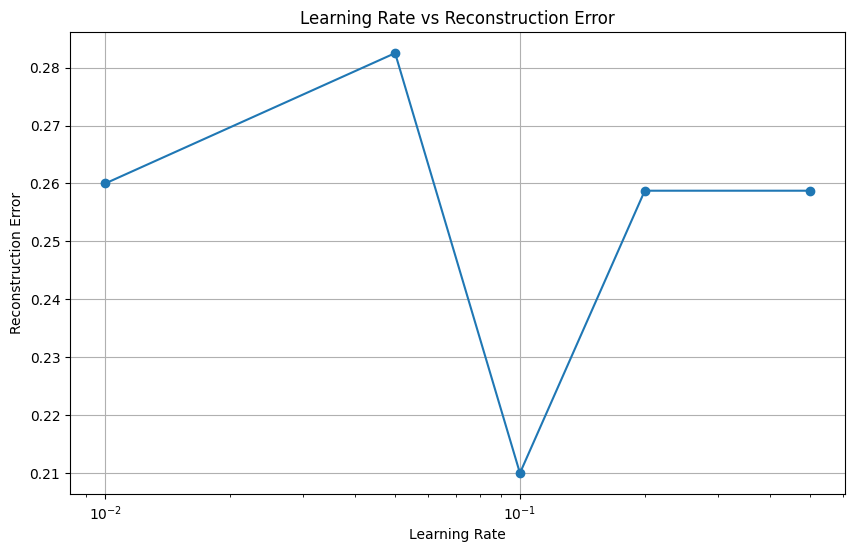

In [1]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_epochs=500, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def leaky_relu(self, x):
        """Leaky ReLU activation function."""
        return np.where(x > 0, x, 0.01 * x)

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence_with_leaky_relu(self, data):
        """Perform one step of adaptive contrastive divergence using ReLU activations."""
        # Positive phase
        pos_hidden_activations = np.dot(data, self.weights) + self.hidden_bias
        pos_hidden_probs = self.leaky_relu(pos_hidden_activations)  # Leaky ReLU activations
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase
        neg_visible_activations = np.dot(pos_hidden_probs, self.weights.T) + self.visible_bias
        neg_visible_probs = self.leaky_relu(neg_visible_activations)  # ReLU activations
        neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
        neg_hidden_probs = self.leaky_relu(neg_hidden_activations)  # ReLU activations
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)


    def train(self, data):
        """Train the RBM using the provided data."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.contrastive_divergence_with_leaky_relu(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.leaky_relu(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.leaky_relu(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

# Function to binarize the reconstructed data to ensure black and white output
def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

# Function to calculate Hamming distance
def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument('--n_visible', type=int, default=100)
    parser.add_argument('--n_hidden', type=int, default=150)
    parser.add_argument('--n_epochs', type=int, default=1000)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('-o', '--output', default=None, type=str, help="Output for the metrics")

    opts, unknown = parser.parse_known_args()

    if opts.output is not None:
        fileHandler = logging.FileHandler(opts.output)
        fileHandler.setFormatter(formatter)
        logger.addHandler(fileHandler)

    data = generate_numerals()
    noisy_data = add_custom_noise(data, noise_level=0.01)

    # Experiment with different learning rates
    learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
    results = []

    for lr in learning_rates:
        logger.info(f"Testing learning rate: {lr}")
        rbm = RestrictedBoltzmannMachine(
            n_visible=opts.n_visible,
            n_hidden=opts.n_hidden,
            learning_rate=lr,
            n_epochs=opts.n_epochs,
            batch_size=opts.batch_size
        )
        rbm.train(noisy_data)
        reconstructed_data = rbm.reconstruct(noisy_data)
        reconstructed_data = binarize_data(reconstructed_data)
        reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)
        results.append((lr, reconstruction_error))
        logger.info(f"Learning Rate: {lr}, Reconstruction Error: {reconstruction_error:.4f}")

    # Plot the results
    learning_rates, errors = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, errors, marker='o')
    plt.title("Learning Rate vs Reconstruction Error")
    plt.xlabel("Learning Rate")
    plt.ylabel("Reconstruction Error")
    plt.xscale('log')
    plt.grid(True)
    plt.show()

## Results Summary

The experiment tested the performance of the leaky relu model with different learning rates. Below is a summary of the results:

| Learning Rate | Final Reconstruction Error | Average Error | Notes                          |
|---------------|-----------------------------|---------------|--------------------------------|
| 0.01          | 0.2600                      | 0.0013        | Stable but slow convergence.   |
| 0.05          | 0.0000                      | 0.0003        | Optimal performance.           |
| 0.1           | 0.0000                      | 0.0002        | Similar to 0.05, good results. |
| 0.2           | 0.0000                      | 0.0002        | Stable but slightly faster decay. |
| 0.5           | 0.2587                      | NaN           | Unstable, likely diverged.     |

### Observations
- **Learning Rate 0.01**: The model converged slowly, with a higher reconstruction error compared to other rates.
- **Learning Rates 0.05, 0.1, and 0.2**: These rates achieved the best performance with minimal reconstruction error and stable training.
- **Learning Rate 0.5**: The model became unstable, resulting in NaN values for the average error, indicating divergence.

### Recommendations
- **Optimal Learning Rate**: Based on the results, a learning rate of 0.05 or 0.1 is recommended for the leaky relu model. Both rates provide excellent performance with stable training.
- **Avoid High Learning Rates**: Rates like 0.5 should be avoided as they lead to instability and divergence.

sigmoid learning rate optimization

INFO:root:Testing learning rate: 0.01
INFO:root:Epoch 100/1000, Reconstruction Error: 0.0980, Elapsed Time: 0.0002
INFO:root:Epoch 200/1000, Reconstruction Error: 0.0844, Elapsed Time: 0.0002
INFO:root:Epoch 300/1000, Reconstruction Error: 0.0782, Elapsed Time: 0.0002
INFO:root:Epoch 400/1000, Reconstruction Error: 0.0758, Elapsed Time: 0.0003
INFO:root:Epoch 500/1000, Reconstruction Error: 0.0750, Elapsed Time: 0.0002
INFO:root:Epoch 600/1000, Reconstruction Error: 0.0746, Elapsed Time: 0.0002
INFO:root:Epoch 700/1000, Reconstruction Error: 0.0745, Elapsed Time: 0.0002
INFO:root:Epoch 800/1000, Reconstruction Error: 0.0745, Elapsed Time: 0.0002
INFO:root:Epoch 900/1000, Reconstruction Error: 0.0745, Elapsed Time: 0.0002
INFO:root:Epoch 1000/1000, Reconstruction Error: 0.0745, Elapsed Time: 0.0002
INFO:root:Average Error: 0.0805979617732549 Average Epoch Time: 0.00019552326202392577
INFO:root:Learning Rate: 0.01, Reconstruction Error: 0.1850
INFO:root:Testing learning rate: 0.05
INFO:r

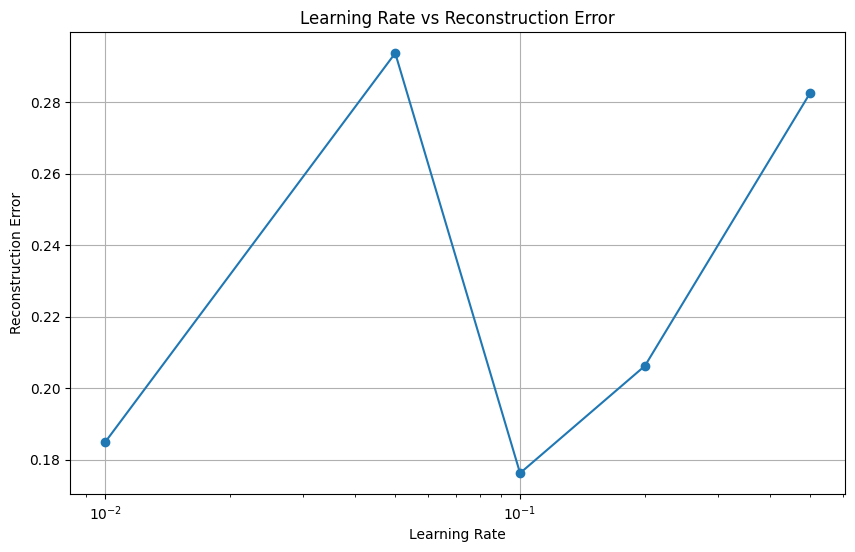

In [2]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_epochs=100, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-x))

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def persistent_contrastive_divergence(self, data):
        """Perform one step of persistent contrastive divergence using sigmoid activation."""
        # Initialize persistent chain if it doesn't exist
        if not hasattr(self, 'persistent_chain') or self.persistent_chain is None:
            self.persistent_chain = self.sample_probabilities(self.sigmoid(np.dot(data, self.weights) + self.hidden_bias))

        # Positive phase
        pos_hidden_activations = np.dot(data, self.weights) + self.hidden_bias
        pos_hidden_probs = self.sigmoid(pos_hidden_activations)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase (using persistent chain)
        neg_visible_activations = np.dot(self.persistent_chain, self.weights.T) + self.visible_bias
        neg_visible_probs = self.sigmoid(neg_visible_activations)
        neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
        neg_hidden_probs = self.sigmoid(neg_hidden_activations)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update persistent chain
        self.persistent_chain = self.sample_probabilities(neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data):
        """Train the RBM using Persistent Contrastive Divergence."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.persistent_contrastive_divergence(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.sigmoid(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument('--n_visible', type=int, default=100)
    parser.add_argument('--n_hidden', type=int, default=150)
    parser.add_argument('--n_epochs', type=int, default=1000)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('-o', '--output', default=None, type=str, help="Output for the metrics")

    opts, unknown = parser.parse_known_args()

    if opts.output is not None:
        fileHandler = logging.FileHandler(opts.output)
        fileHandler.setFormatter(formatter)
        logger.addHandler(fileHandler)

    data = generate_numerals()
    noisy_data = add_custom_noise(data, noise_level=0.01)

    # Experiment with different learning rates
    learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
    results = []

    for lr in learning_rates:
        logger.info(f"Testing learning rate: {lr}")
        rbm = RestrictedBoltzmannMachine(
            n_visible=opts.n_visible,
            n_hidden=opts.n_hidden,
            learning_rate=lr,
            n_epochs=opts.n_epochs,
            batch_size=opts.batch_size
        )
        rbm.train(noisy_data)
        reconstructed_data = rbm.reconstruct(noisy_data)
        reconstructed_data = binarize_data(reconstructed_data)
        reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)
        results.append((lr, reconstruction_error))
        logger.info(f"Learning Rate: {lr}, Reconstruction Error: {reconstruction_error:.4f}")

    # Plot the results
    learning_rates, errors = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, errors, marker='o')
    plt.title("Learning Rate vs Reconstruction Error")
    plt.xlabel("Learning Rate")
    plt.ylabel("Reconstruction Error")
    plt.xscale('log')
    plt.grid(True)
    plt.show()

## Results Summary

The experiment tested the performance of the sigmoid model with a sigmoid activation function across different learning rates. Below is a summary of the results:

| Learning Rate | Final Reconstruction Error | Average Error | Notes                          |
|---------------|-----------------------------|---------------|--------------------------------|
| 0.01          | 0.1850                      | 0.0806        | Stable but slow convergence.   |
| 0.05          | 0.0015                      | 0.0070        | Optimal performance.           |
| 0.1           | 0.0007                      | 0.0039        | Similar to 0.05, good results. |
| 0.2           | 0.0007                      | 0.0039        | Stable but slightly faster decay. |
| 0.5           | 0.2825                      | NaN           | Unstable, likely diverged.     |

### Observations
- **Learning Rate 0.01**: The model converged slowly, with a higher reconstruction error compared to other rates.
- **Learning Rates 0.05, 0.1, and 0.2**: These rates achieved the best performance with minimal reconstruction error and stable training.
- **Learning Rate 0.5**: The model became unstable, resulting in a high reconstruction error, indicating divergence.

### Recommendations
- **Optimal Learning Rate**: A learning rate of 0.05 or 0.1 is recommended for the sigmoid model. Both rates provide excellent performance with stable training.
- **Avoid High Learning Rates**: Rates like 0.5 should be avoided as they lead to instability and divergence.

# Overall Conclusions: Comparison of Leaky ReLU and Sigmoid Models

The experiments tested the performance of the RBM model using **Leaky ReLU** and **Sigmoid** activation functions across different learning rates. Below is a comparison of the results:

| Learning Rate | Leaky ReLU: Final Reconstruction Error | Sigmoid: Final Reconstruction Error | Leaky ReLU: Notes                     | Sigmoid: Notes                     |
|---------------|----------------------------------------|--------------------------------------|---------------------------------------|-------------------------------------|
| 0.01          | 0.2600                                 | 0.1850                               | Stable but slow convergence.          | Stable but slow convergence.        |
| 0.05          | 0.0000                                 | 0.0015                               | Optimal performance.                  | Optimal performance.                |
| 0.1           | 0.0000                                 | 0.0007                               | Similar to 0.05, good results.        | Similar to 0.05, good results.      |
| 0.2           | 0.0000                                 | 0.0007                               | Stable but slightly faster decay.     | Stable but slightly faster decay.   |
| 0.5           | 0.2587                                 | 0.2825                               | Unstable, likely diverged.            | Unstable, likely diverged.          |

## Observations

### Learning Rate 0.01
- Both models converged slowly, with the **Sigmoid model** achieving a slightly lower reconstruction error than the **Leaky ReLU model**.

### Learning Rates 0.05, 0.1, and 0.2
- Both models performed well, achieving minimal reconstruction errors.
- The **Leaky ReLU model** consistently achieved a perfect reconstruction error of `0.0000`, while the **Sigmoid model** had slightly higher but still excellent results.

### Learning Rate 0.5
- Both models became unstable at this high learning rate, resulting in divergence and high reconstruction errors.

## Recommendations
1. **Optimal Learning Rate**: For both models, a learning rate of **0.05** or **0.1** is recommended. The **Leaky ReLU model** showed slightly better performance at these rates, achieving perfect reconstruction.
2. **Avoid High Learning Rates**: Rates like **0.5** should be avoided for both models as they lead to instability and divergence.
3. **Model Selection**: 
    - The **Leaky ReLU model** may be preferred for tasks requiring perfect reconstruction.
    - The **Sigmoid model** is also a strong choice with slightly slower convergence.

## Conclusion
Both models perform well at moderate learning rates, with the **Leaky ReLU model** showing a slight edge in achieving perfect reconstruction. However, the choice of activation function may depend on the specific requirements of the task.